<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE</span></p>
<p><font size="4">  UE Numerical Methods </font></p>
<p></p>
<p><font size="5">  PROJET </font></p>

**<p><font size="5">  Students NAME and FAMILY NAME: Kévin FERREIRA, Elias TRANCHANT </font></p>**
</p></br>
</p>
</CENTER>

# I. Introduction

In [1]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images


#pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

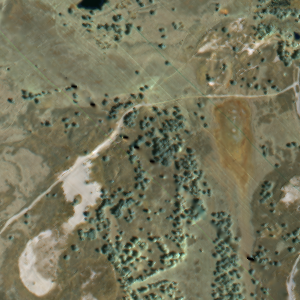

In [2]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

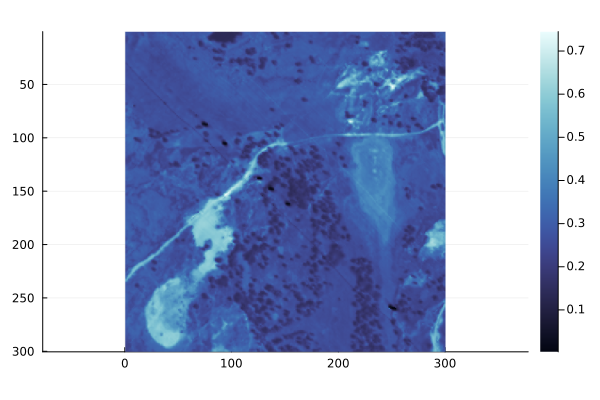

In [3]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

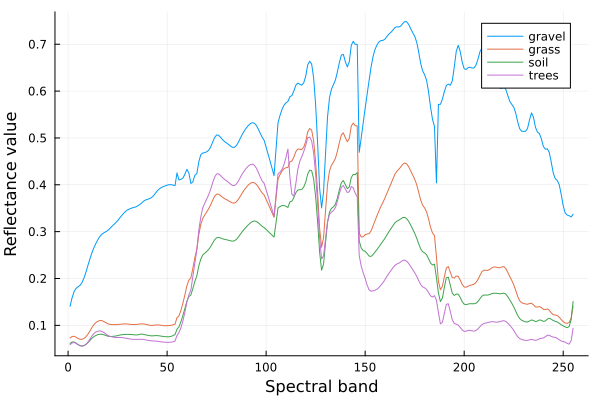

In [4]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# II. Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

# II. Gradient algorithm with backtracking with only the negativity constraint

**First, we have to minimize: 
\begin{equation*}
\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = 
\frac{1}{2}(\mathbf{X}-\mathbf{SA})^{T}(\mathbf{X}-\mathbf{SA})
\end{equation*}
Lets \begin{equation*}
Q = S^{T}S, p=S^{T}X, c= \frac{1}{2}(X^{T}X)
\end{equation*}
So, the function to minimize is 
\begin{equation*}
f(A) = \frac{1}{2} A^{T}QA-p^{T}A+c
\end{equation*}**

## a.  Fully global implementation 

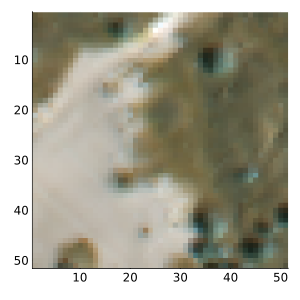

In [228]:
# load image
img_small = img[150:200,70:120,:]; # use a small crop of the image first
#img_small = copy(img);

# plot
rgb_small = rgb[150:200,70:120,:]
#rgb_small = copy(rgb)
p1 = colorview(RGB,permutedims(rgb_small,(3,1,2))) # convert 3d array to the image format used by julia
plot(p1)
plot!(size=(300,300))

In [229]:
# size parameters
L = size(sources)[1]
P = size(sources)[2]
N = size(img_small)[1] * size(img_small)[2]

# variables
S = sources
X = reshape(img_small, (L, N)) 

Q = S'*S
p = S'*X
c = (1/2)*(X'*X)

# function to optimize
f(A) = (1/2)*norm(X-S*A)^2
∇f(A)= S'*(S*A-X) 

∇f (generic function with 1 method)

In [230]:
# Lipschitz
#-------------
using LinearAlgebra

function stepsize(S)
    L = opnorm(S'*S)
    s = 2/L
    s
end

stepsize (generic function with 1 method)

In [275]:
# Negative constraint
#-------------
function c_neg(y)
    u = copy(y)
    for i in range(1,length(y))
        u[i] = max(0, u[i])
    end
    u
end

# One constraint
#-------------
function c_one(y)
    u = copy(y)
    for i in range(1,size(u)[2])
        if sum(u[:,i]) == 0
            u[:,i] = u[:,i] + 0.25*ones(size(u)[1],1)
        else
            sum_to_one = 1/sum(u[:,i]) - 1
            u[:,i] = u[:,i] + sum_to_one * u[:,i]
        end
    end
    return u
end

c_one (generic function with 1 method)

In [282]:
#Project gradient
#-----------------
function project_gradient(X, S, ∇f)

    prec        = 1.e-4

    init      = randn(P, N)
    A         = init
    A_prec    = zeros(P,N)

    nb_iter   = 0  # number of loops
    nb_loops  = 0  # number of inner loops count for backtracking
    max_iter  = 1000

    result    = A
    err       = norm(X-S*A)
    
    t = stepsize(S)

    while norm(A_prec-A) > prec && nb_iter<max_iter
        A_prec = copy(A)
    
        d = - ∇f(A)
        A = A+t*d
    
        A = c_neg(A)
        A = c_one(A)
        
        result = [result A]
        err    = [err norm(X-S*A)]
    end
    return result, err, A
end
    

project_gradient (generic function with 2 methods)

In [283]:
@time result, err, A = project_gradient(X, S, ∇f)

println("C_neg: ", min(A...), " - ",max(A...))
L = ones(N,P)*A
println("C_one: ", min(L...), " - ",max(L...))

  5.520017 seconds (3.74 M allocations: 6.726 GiB, 20.61% gc time, 2.58% compilation time)
C_neg: 0.0 - 1.0
C_one: 0.9999999999999998 - 1.0000000000000004


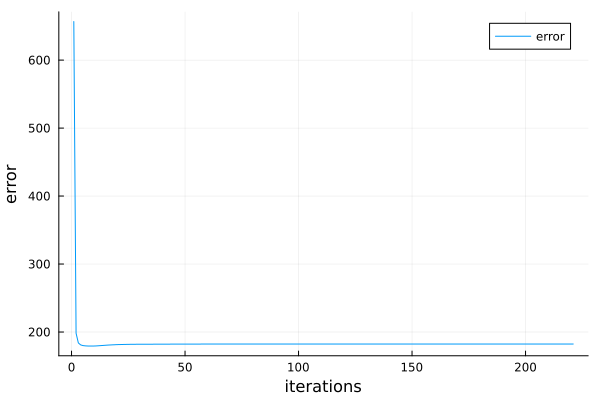

In [293]:
plot(err', xlabel="iterations", ylabel="error", label="error")

In [294]:
p = zeros(4)
for i in range(1, size(A)[1])
    p[i] = sum(A[i,:])
end
p = (1/sum(A)) * p
println( "gravel : ", p[1])
println( "grass : ", p[2])
println( "soil : ", p[3])
println( "trees : ", p[4])

gravel : 0.4286486618013432
grass : 0.1936011179045692
soil : 0.2171616089398477
trees : 0.16058861135423996


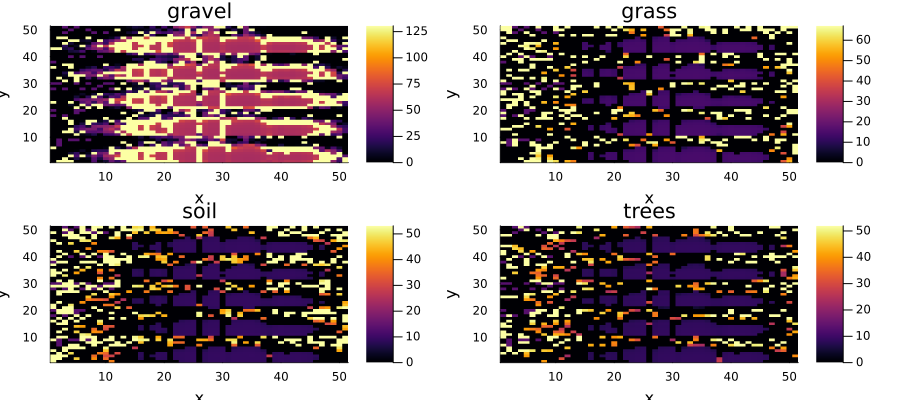

In [295]:
using Plots

h1 = heatmap(reshape(ones(1, size(S)[1])*S[:,1]*A[1,:]', size(img_small)[1:2]) , xlabel="x", ylabel="y", title="gravel")
h2 = heatmap(reshape(ones(1, size(S)[1])*S[:,2]*A[2,:]', size(img_small)[1:2]) , xlabel="x", ylabel="y", title="grass")
h3 = heatmap(reshape(ones(1, size(S)[1])*S[:,3]*A[3,:]', size(img_small)[1:2]) , xlabel="x", ylabel="y", title="soil")
h4 = heatmap(reshape(ones(1, size(S)[1])*S[:,4]*A[4,:]', size(img_small)[1:2]) , xlabel="x", ylabel="y", title="trees")

plot(h1, h2, h3, h4, layout = (2,2))
plot!(size=(900,400))

In [297]:
using Plots
A_th = inv(S'*S)*S'*X
p = zeros(4)
for i in range(1, size(A)[1])
    p[i] = sum(A_th[i,:])
end
p = (1/sum(A_th)) * p
println( "gravel : ", p[1])
println( "grass : ", p[2])
println( "soil : ", p[3])
println( "trees : ", p[4])

gravel : 1.2734378375826636
grass : -2.7470779001687
soil : 1.1250667794753284
trees : 1.348573283110708


## b.  Global implementation with a for loop

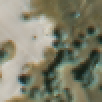

In [20]:
img_small = img[175:225,50:150,:]; # use a small crop of the image first
#img_small = copy(img);

rgb_small = rgb[175:225,75:125,:]
#rgb_small = copy(rgb)
p1 = colorview(RGB,permutedims(rgb_small,(3,1,2))) # convert 3d array to the image format used by julia

In [21]:
L = size(sources)[1]
P = size(sources)[2]
N = size(img_small)[1] * size(img_small)[2]

S = sources
X = reshape(img_small, (L, N)) 

Q = S'*S
p = S'*X
c = (1/2)*(X'*X)

f(A)=(1/2)*A'*Q*A-p'*A+c + ones(1,P)*A - ones(1,N)
∇f(A,X)=S'*S*A-S'*X

∇f (generic function with 2 methods)

In [25]:
prec        = 1.e-3

init      = ones(P,N)*0.25
A         = init


nb_iter   = 0  # number of loops
nb_loops  = 0  # number of inner loops count for backtracking
max_iter  = 10e4

result      = A

α = 0.1
t = stepsize(S)
for i in range(1, size(X)[2])
    print(i, " ")
    A_prec    = zeros(size(A)[1],1)
    
    while norm(A_prec - A[:,i]) > prec && nb_iter<max_iter
        A_prec = copy(A[:,i])
        
        A[:,i] = A[:,i] - t*∇f(A[:,i],X[:,i])
        
        A[:,i] = c_neg(A[:,i])
        #d = c_one_2(A_neg)-A_prec
        
    
        result = [result A[:,i]]
        nb_iter +=1 
    end
end

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

LoadError: InterruptException:

In [48]:
function c_neg(y)
    u = copy(y)
    for i in range(1,length(y))
        u[i] = max(0, y[i])
    end
    u
end

function c_one_2(y)
    u = copy(y)
    u = u+(1/size(u)[1])*(1-sum(u))*ones(size(u))
    return u
end

c_one_2 (generic function with 1 method)

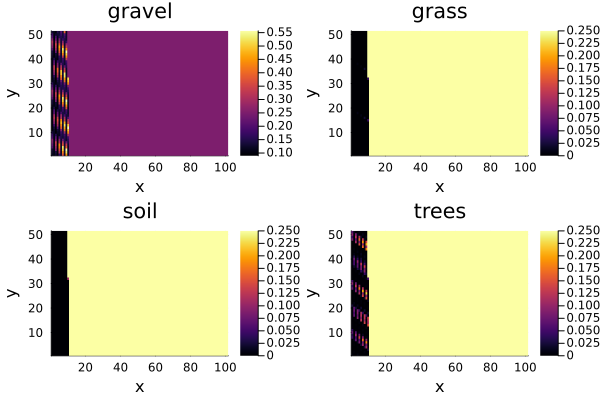

In [26]:
using Plots

data = rand(21,100)
h1 = heatmap(reshape(A[1,:], size(img_small)[1:2]) , xlabel="x", ylabel="y", title="gravel")
h2 = heatmap(reshape(A[2,:], size(img_small)[1:2]) , xlabel="x", ylabel="y", title="grass")
h3 = heatmap(reshape(A[3,:], size(img_small)[1:2]) , xlabel="x", ylabel="y", title="soil")
h4 = heatmap(reshape(A[4,:], size(img_small)[1:2]) , xlabel="x", ylabel="y", title="trees")

plot(h1,h2,h3,h4, layout = 4)